!gdown 1LGHpPp0KXnCRDtJD2alvyvaiNaJ7eDT3 # A3266 image from E-Rosita public data
!gdown 1PLvzBbae0EANWBLggqgwPDwecsx7sxLF # A3266 exposure map

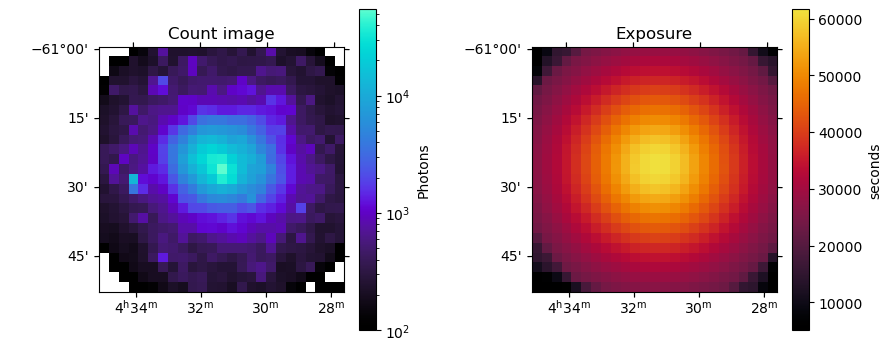

In [2]:
import matplotlib.pyplot as plt
import warnings
import cmasher as cmr
import numpy as np
from astropy.io import fits
from astropy.nddata import block_reduce
from astropy.wcs import WCS
from matplotlib.colors import LogNorm

# Load the data

img_uncropped = fits.getdata('/Users/radam/Downloads/a3266_img_erosita.fits')
exp_uncropped = fits.getdata('/Users/radam/Downloads/a3266_exp_erosita.fits')

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    wcs = WCS(header = fits.getheader('/Users/radam/Downloads/a3266_img_erosita.fits'), relax=True)

# Crop to the central parts

size = 400
x_min, y_min = 1620-size, 1620-size#coords.min(axis=0)
x_max, y_max = 1620+size, 1620+size#coords.max(axis=0)
img = img_uncropped[x_min:x_max+1, y_min:y_max+1]
exp = exp_uncropped[x_min:x_max+1, y_min:y_max+1]
wcs = wcs[x_min:x_max+1, y_min:y_max+1]

# Rebin to lower number
reduction_factor = 32
img = block_reduce(img, reduction_factor, np.sum)
exp = block_reduce(exp, reduction_factor, np.mean)
wcs = wcs[::reduction_factor, ::reduction_factor]
# Display the data

plt.figure(figsize=(9,4))
ax = plt.subplot(121, projection=wcs)
ax.coords[0].set_axislabel(' ')
ax.coords[1].set_axislabel(' ')
mappable = ax.imshow(img, norm=LogNorm(vmin=1e2), cmap=cmr.cosmic)
plt.title('Count image')
plt.colorbar(mappable=mappable, label='Photons')

ax = plt.subplot(122, projection=wcs)
ax.coords[0].set_axislabel(' ')
ax.coords[1].set_axislabel(' ')
mappable = ax.imshow(exp, cmap=cmr.ember)
plt.title('Exposure')
plt.colorbar(mappable=mappable, label='seconds')
plt.tight_layout()

In [3]:
import numpy as np
import torch

def beta_model(r, **kwargs):
    """
    Implementation of a surface brightness beta-model
    """

    norm = kwargs.get('norm', 1)
    r_c = kwargs.get('r_c', 4*3.)
    beta = kwargs.get('beta', 3/2)

    return norm*(1 + (r/r_c)**2)**(-3*beta/2)

def counts(exp, **kwargs):

    x, y = np.indices(exp.shape)
    x_c = kwargs.get('x_c', exp.shape[0]//2)
    y_c = kwargs.get('y_c', exp.shape[1]//2)
    bkg = kwargs.get('bkg', 1e-6)

    r = np.hypot(x-x_c,y-y_c)

    sb = beta_model(r, **kwargs)

    return (sb + bkg)*exp


def simulator(theta):
    """
    Simulating galaxy cluster images with Poisson noise
    """

    norm, r_c, beta, x_c, y_c, bkg = np.asarray(theta)
    parameters = dict(norm=norm, r_c=r_c, beta=beta, x_c=x_c, y_c=y_c, bkg=bkg)
    expected_counts = counts(exp, **parameters)

    return np.random.poisson(expected_counts).flatten()

# Vanilla example

In [4]:
import torch
from sbi import utils as utils
from sbi.inference import infer

num_dim = 6

prior = utils.BoxUniform(
    low=torch.FloatTensor([0., 0., 0., 15./2, 15./2, 0.]),
    high=torch.FloatTensor([3., 20., 2., 35./2, 35./2, 1e-3])
    )

posterior = infer(simulator, prior, method='SNPE', num_simulations=1000)

/Users/radam/Project/anaconda3/envs/main/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 14879.59it/s]


 Neural network successfully converged after 168 epochs.

In [5]:
samples = posterior.sample((100_000,), x=img.flatten())

Drawing 100000 posterior samples: 101771it [00:02, 38092.97it/s]                                                                                                                                                                                               


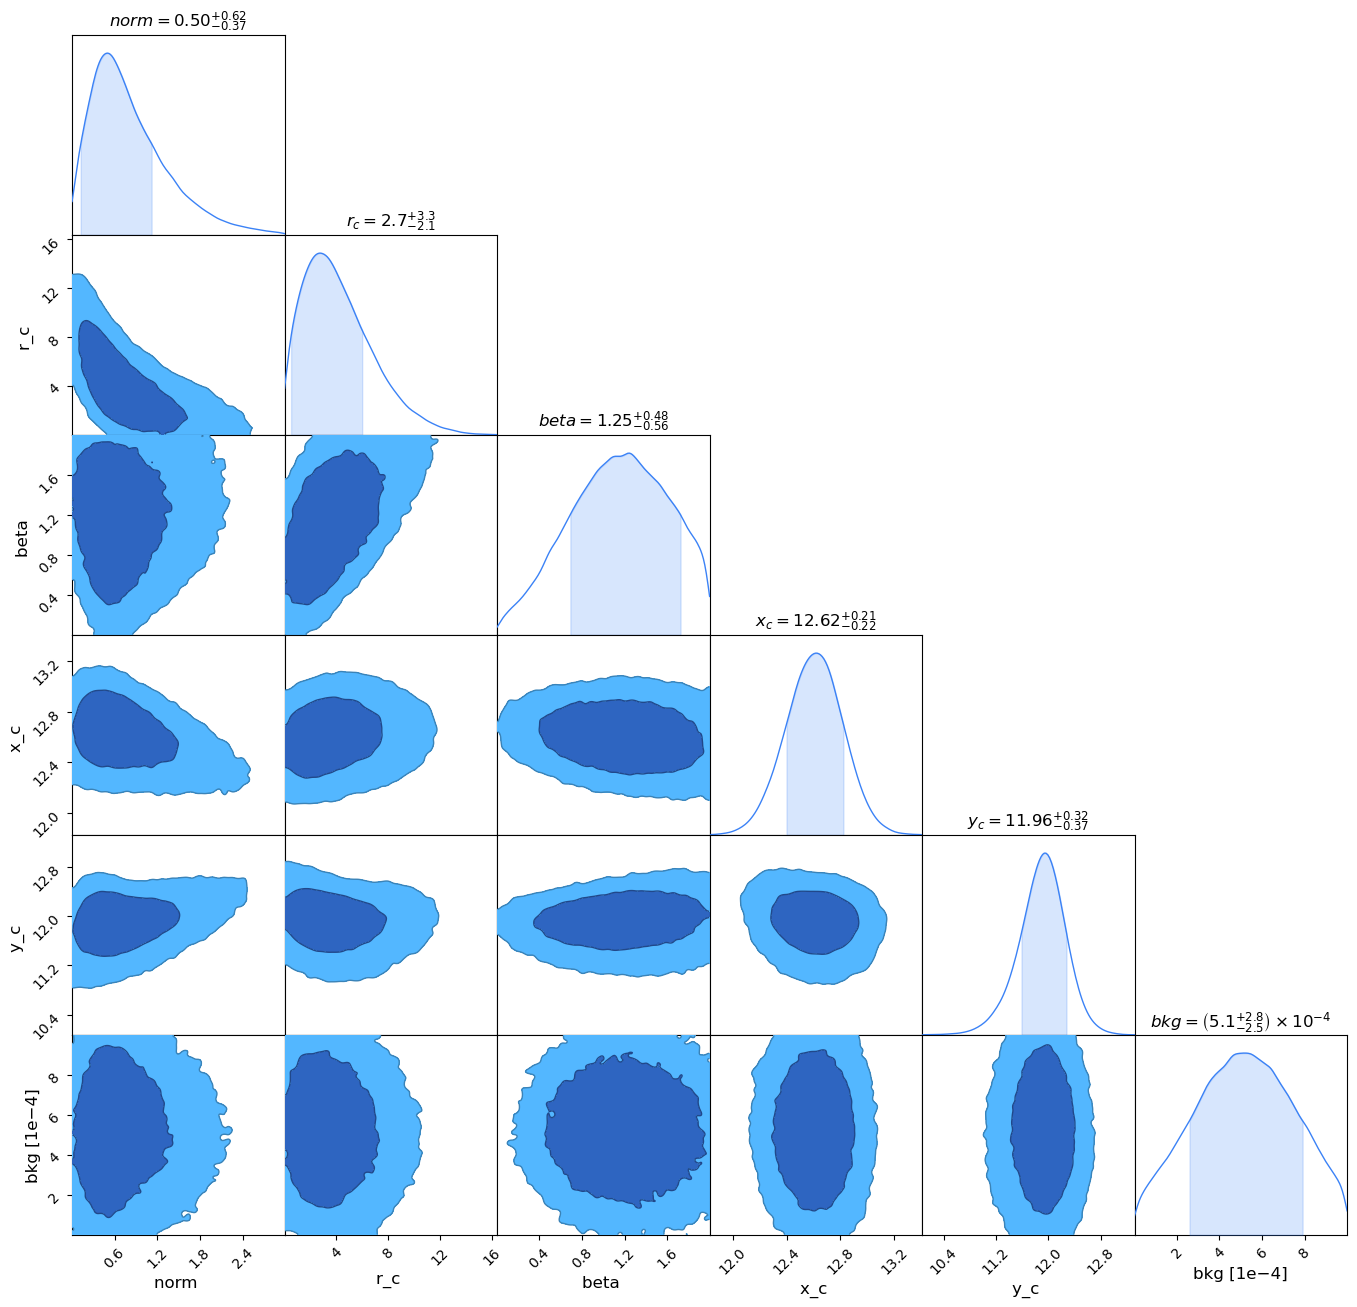

In [6]:
import pandas as pd
from chainconsumer import ChainConsumer, Chain
samples_df = pd.DataFrame.from_dict({par:np.asarray(samples[:, i]) for i, par in enumerate(['norm', 'r_c', 'beta', 'x_c', 'y_c', 'bkg'])})
chain_vanilla = Chain(samples = samples_df, name="Vanilla results")
cc = ChainConsumer()
cc.add_chain(chain_vanilla)
cc.plotter.plot();

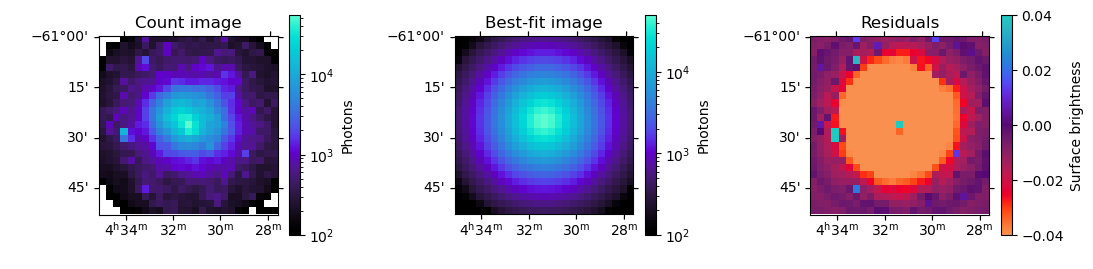

In [7]:
norm, r_c, beta, x_c, y_c, bkg = np.asarray(samples.mean(axis=0))
best_fit_parameters = dict(norm=norm, r_c=r_c, beta=beta, x_c=x_c, y_c=y_c, bkg=bkg)
best_fit_image = np.asarray(counts(exp, **best_fit_parameters))

plt.figure(figsize=(11,3))
ax = plt.subplot(131, projection=wcs)
ax.coords[0].set_axislabel(' ')
ax.coords[1].set_axislabel(' ')
mappable = ax.imshow(img, norm=LogNorm(vmin=1e2), cmap=cmr.cosmic)
plt.title('Count image')
plt.colorbar(mappable=mappable, label='Photons')

ax = plt.subplot(132, projection=wcs)
ax.coords[0].set_axislabel(' ')
ax.coords[1].set_axislabel(' ')
mappable = ax.imshow(best_fit_image, norm=LogNorm(vmin=1e2), cmap=cmr.cosmic)
plt.title('Best-fit image')
plt.colorbar(mappable=mappable, label='Photons')

ax = plt.subplot(133, projection=wcs)
ax.coords[0].set_axislabel(' ')
ax.coords[1].set_axislabel(' ')
mappable = ax.imshow((img-best_fit_image)/exp, cmap=cmr.guppy, vmin=-0.04, vmax=0.04)
plt.title('Residuals')
plt.colorbar(mappable=mappable, label='Surface brightness')
plt.tight_layout()

# Example with embedding

In [8]:
def simulator_image(theta):
    """
    Simulating galaxy cluster images with Poisson noise without flattening
    """

    norm, r_c, beta, x_c, y_c, bkg = np.asarray(theta)
    parameters = dict(norm=norm, r_c=r_c, beta=beta, x_c=x_c, y_c=y_c, bkg=bkg)
    expected_counts = counts(exp, **parameters)

    return np.random.poisson(expected_counts)

In [9]:
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import CNNEmbedding
from sbi.inference import SNPE, simulate_for_sbi
from sbi.utils.user_input_checks import process_simulator

# We add a CNN for embedding
embedding_net = CNNEmbedding(input_shape=img.shape)

neural_posterior = posterior_nn(model="maf", embedding_net=embedding_net)
inference = SNPE(prior=prior, density_estimator=neural_posterior)
simulator_wrapper = process_simulator(simulator_image, prior, False)
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=5_000) # More simulations
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 20300.61it/s]


 Neural network successfully converged after 200 epochs.

In [10]:
samples = posterior.sample((100_000,), x=img)

Drawing 100000 posterior samples: 101801it [00:01, 74804.13it/s]                                                                                                                                                                                               


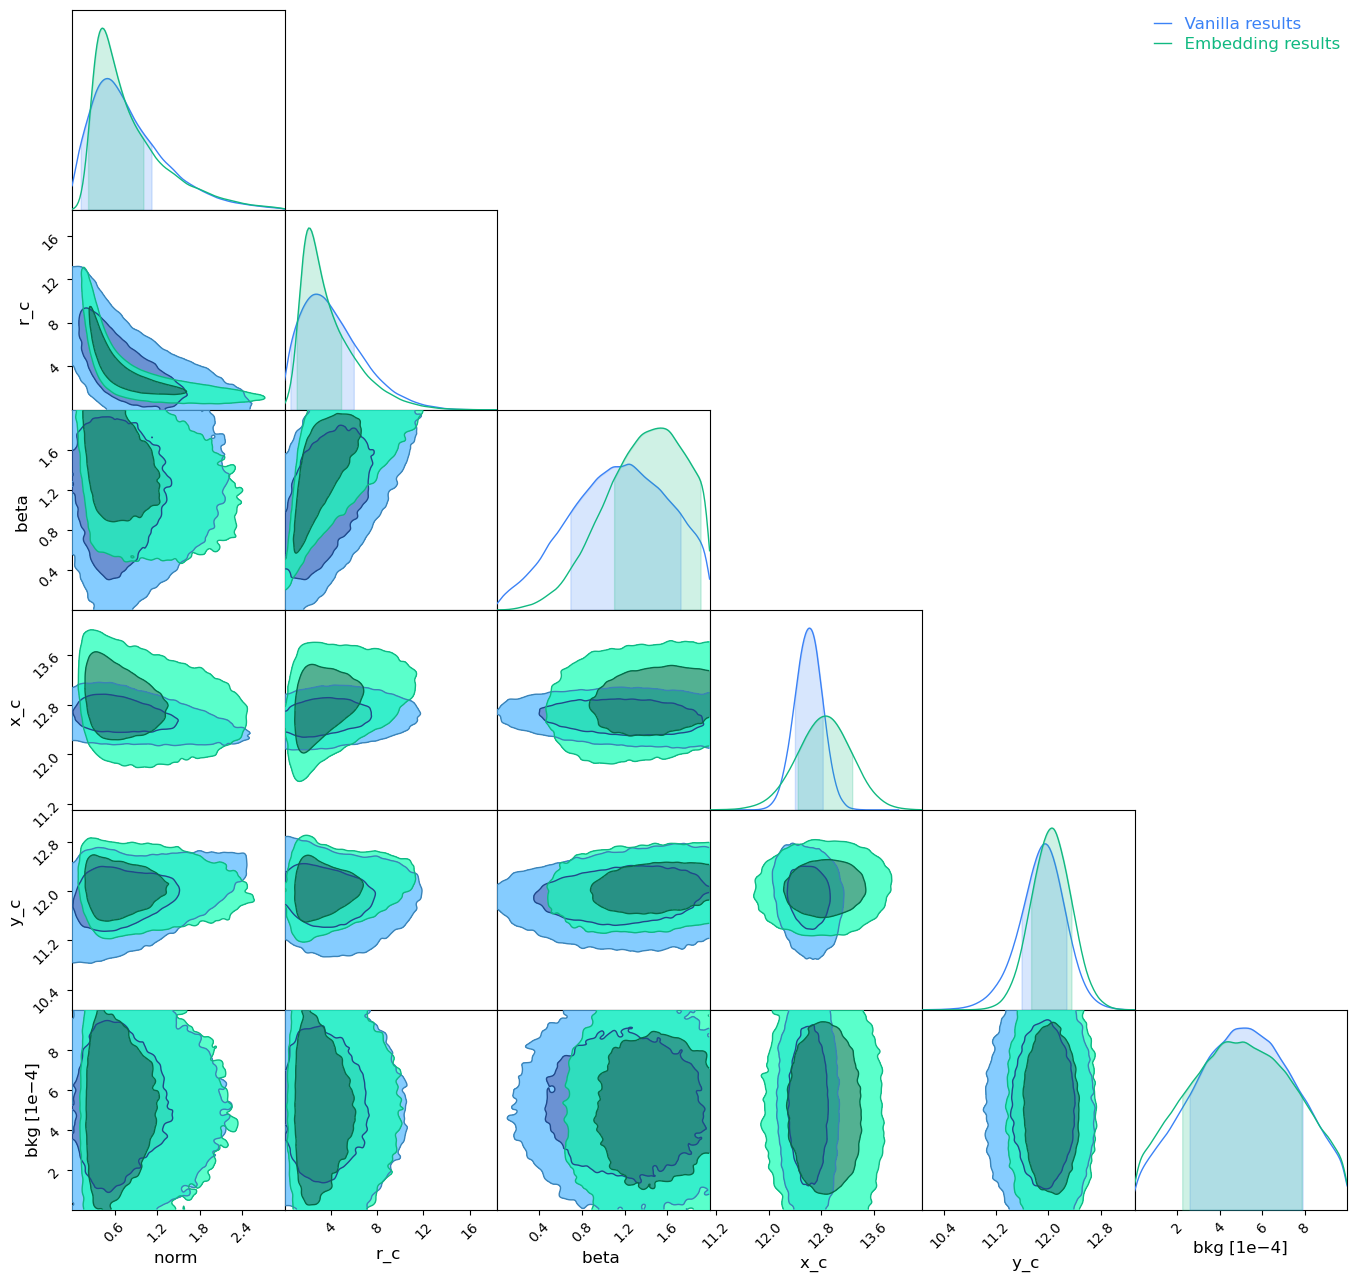

In [11]:
import pandas as pd
from chainconsumer import ChainConsumer, Chain
samples_df = pd.DataFrame.from_dict({par:np.asarray(samples[:, i]) for i, par in enumerate(['norm', 'r_c', 'beta', 'x_c', 'y_c', 'bkg'])})
chain_embedding = Chain(samples = samples_df, name="Embedding results")
cc.add_chain(chain_embedding)
cc.plotter.plot();

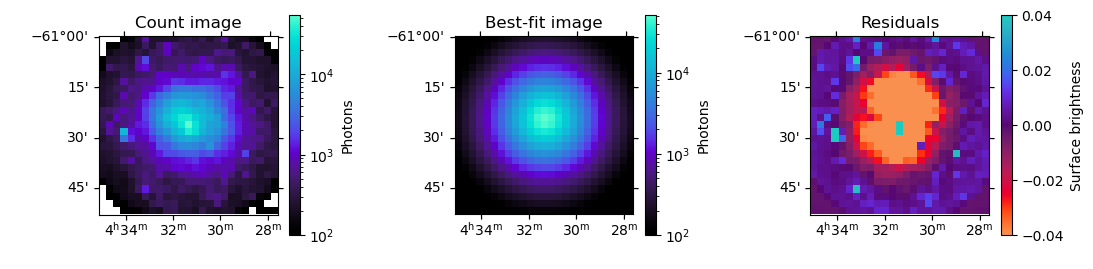

In [12]:
norm, r_c, beta, x_c, y_c, bkg = np.asarray(samples.mean(axis=0))
best_fit_parameters = dict(norm=norm, r_c=r_c, beta=beta, x_c=x_c, y_c=y_c, bkg=bkg)
best_fit_image = np.asarray(counts(exp, **best_fit_parameters))

plt.figure(figsize=(11,3))
ax = plt.subplot(131, projection=wcs)
ax.coords[0].set_axislabel(' ')
ax.coords[1].set_axislabel(' ')
mappable = ax.imshow(img, norm=LogNorm(vmin=1e2), cmap=cmr.cosmic)
plt.title('Count image')
plt.colorbar(mappable=mappable, label='Photons')

ax = plt.subplot(132, projection=wcs)
ax.coords[0].set_axislabel(' ')
ax.coords[1].set_axislabel(' ')
mappable = ax.imshow(best_fit_image, norm=LogNorm(vmin=1e2), cmap=cmr.cosmic)
plt.title('Best-fit image')
plt.colorbar(mappable=mappable, label='Photons')

ax = plt.subplot(133, projection=wcs)
ax.coords[0].set_axislabel(' ')
ax.coords[1].set_axislabel(' ')
mappable = ax.imshow((img-best_fit_image)/exp, cmap=cmr.guppy, vmin=-0.04, vmax=0.04)
plt.title('Residuals')
plt.colorbar(mappable=mappable, label='Surface brightness')
plt.tight_layout()